# Data Preparation

---

This notebook outlines the process for preparing the Zillow property data needed for this project. This notebook also demonstrates the steps to create and test the functions in the util/prepare.py file.

---

## Importing the Required Modules

Below we import all the modules needed to run this notebook. Note that you will need the univariate_analysis.py file located in the notebooks directory in order to run some of the code blocks in this notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from univariate_analysis import get_hist, get_box

from env import username, password, hostname

---

## Acquire Data

Here we define all our acquisition functions created in the acquire notebook.

In [2]:
def get_db_url(database_name, username = username, password = password, hostname = hostname):
    return f'mysql+pymysql://{username}:{password}@{hostname}/{database_name}'

def get_zillow_sql():
    return """
        SELECT
            bedroomcnt,
            bathroomcnt,
            calculatedfinishedsquarefeet,
            taxvaluedollarcnt,
            yearbuilt,
            fips,
            numberofstories,
            basementsqft,
            fireplacecnt,
            heatingorsystemdesc,
            roomcnt,
            garagetotalsqft,
            hashottuborspa,
            poolcnt,
            poolsizesum,
            yardbuildingsqft17
        FROM properties_2017
        JOIN propertylandusetype
            ON propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid
            AND (propertylandusetype.propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential'))
        LEFT JOIN heatingorsystemtype USING (heatingorsystemtypeid)
        JOIN predictions_2017 ON properties_2017.parcelid = predictions_2017.parcelid
            AND predictions_2017.transactiondate LIKE '2017%%';
        """

def get_zillow_data(use_cache = True):
    # If the file is cached, read from the .csv file
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cache')
        return pd.read_csv('zillow.csv')
    
    # Otherwise read from the mysql database
    else:
        print('Reading from database')
        df = pd.read_sql(get_zillow_sql(), get_db_url('zillow'))
        df.to_csv('zillow.csv', index = False)
        return df

In [3]:
# Now we can load our dataset.
properties = get_zillow_data()

Using cache


---

## Initial Analysis (Looking for Unusual Values and Outliers)

We will start by getting an overview of our data and determining whether or not there exist unusual values or outliers that may affect our results.

In [4]:
properties.shape

(52441, 16)

In [5]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,52441.0,3.300681,0.949094,0.0,3.0,3.0,4.00,14.0
bathroomcnt,52441.0,2.299403,1.022772,0.0,2.0,2.0,3.00,18.0
calculatedfinishedsquarefeet,52359.0,1922.890754,1004.365838,128.0,1268.0,1659.0,2306.00,21929.0
taxvaluedollarcnt,52440.0,529688.163921,751894.553363,1000.0,193747.5,373612.0,619301.25,49061236.0
yearbuilt,52325.0,1963.393884,23.133571,1878.0,1950.0,1961.0,1979.00,2016.0
fips,52441.0,6049.132149,21.029067,6037.0,6037.0,6037.0,6059.00,6111.0
numberofstories,14561.0,1.413914,0.540677,1.0,1.0,1.0,2.00,6.0
basementsqft,47.0,678.978723,711.825226,38.0,263.5,512.0,809.50,3560.0
fireplacecnt,7243.0,1.209858,0.512885,1.0,1.0,1.0,1.00,5.0
roomcnt,52441.0,1.893709,3.146437,0.0,0.0,0.0,5.00,15.0


**Takeaways**
- bedroomcnt and bathroomcnt both have minimum values of 0 which might make sense for a studio apartment, but it does seem unusual.
- calculatedfinishedsquarefeet has a minimum value of 1 which doesn't seem right.
- roomcnt has a minimum value of 0 which is unusual.

Now let's look at histograms and boxplots of our features to determine if there are any outliers.

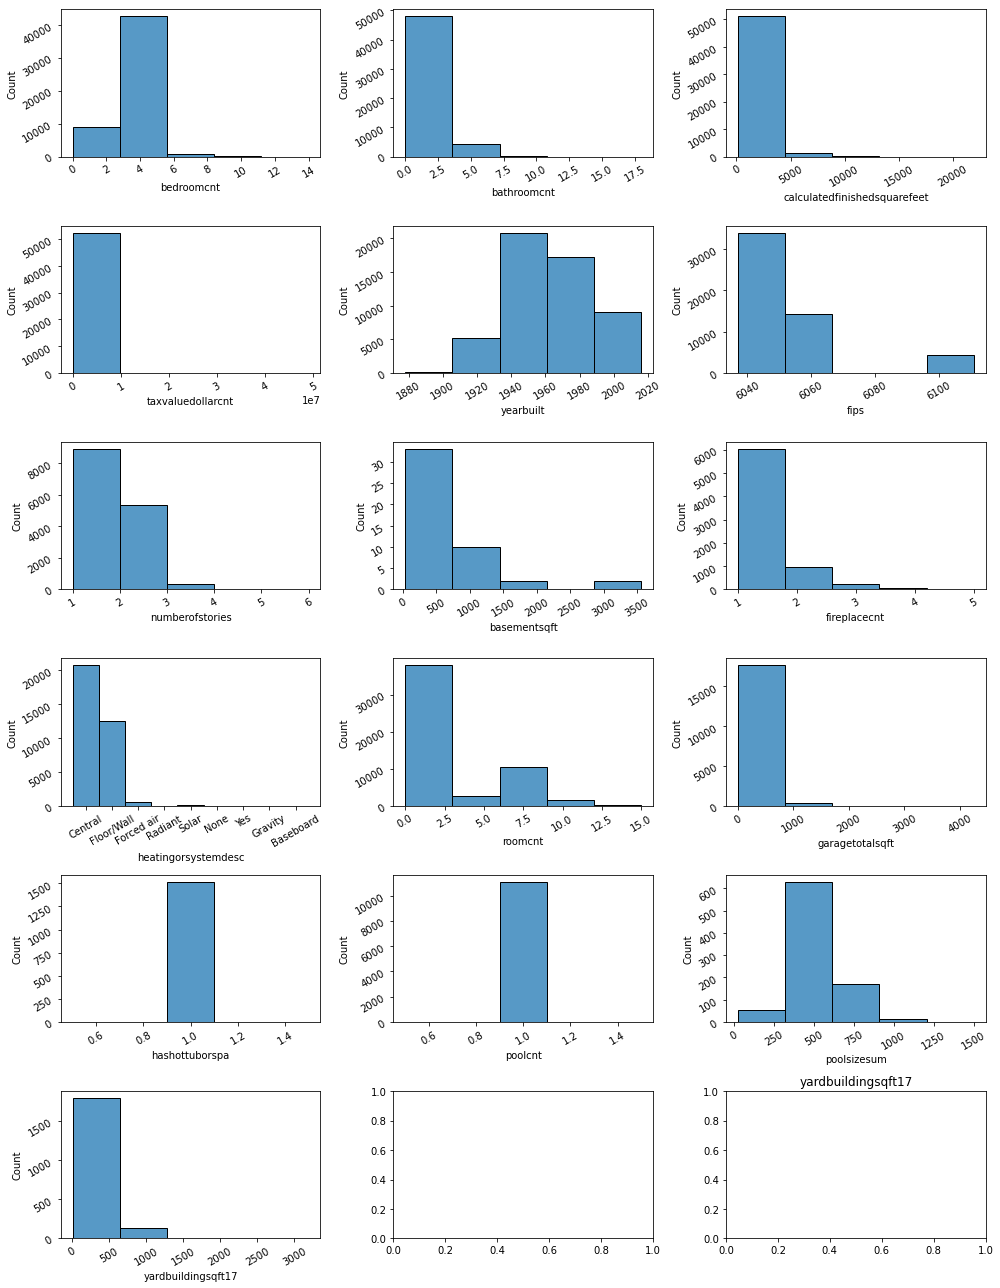

In [6]:
get_hist(properties, properties.columns)

The calculatedfinishedsquarefeet column possibly has some outliers. Let's see the boxplots.

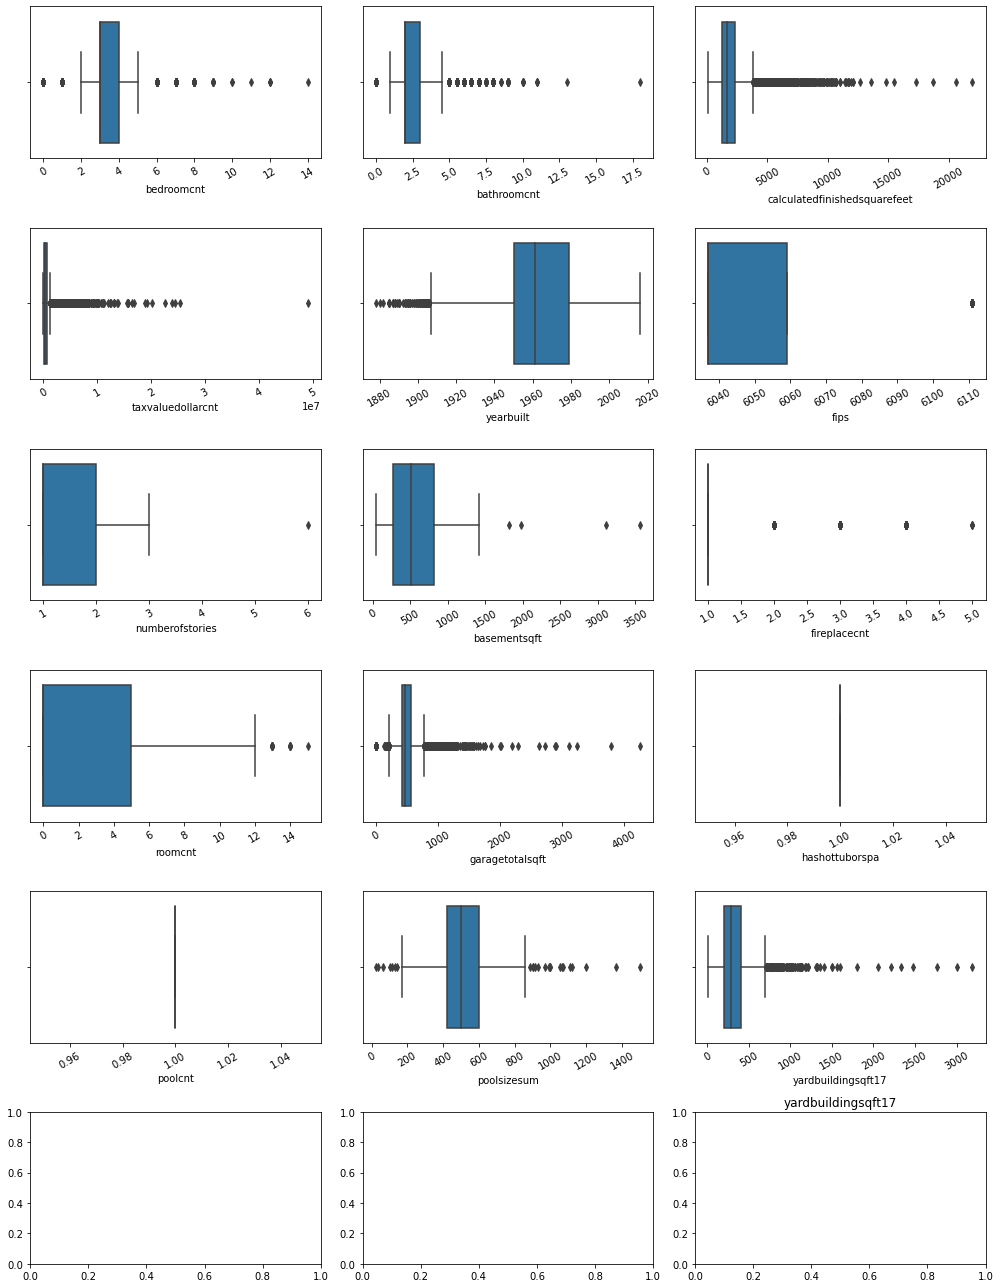

In [7]:
get_box(properties, properties.select_dtypes('number').columns)

The columns with the most pronounced outliers are:
- calculatedfinishedsquarefeet
- yardbuildingsqft17
- garagetotalsqft

taxvaluedollarcnt also has a large number of outliers, but since this is our target variable we'll ignore it.

We'll try removing the outliers in calculatedfinishedsquarefeet.

In [8]:
# Remove outliers

def remove_outliers(df, k, col_list):    
    for col in col_list:
        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

# Must remove outliers only from columns where the values don't make sense otherwise we
# lose almost all our data.

columns = [
    'calculatedfinishedsquarefeet'
]

properties = remove_outliers(properties, 1.5, columns)

With outliers removed let's now take a look at our data again to see if the unusual values were also removed.

In [9]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,50079.0,3.240720,0.884174,0.0,3.00,3.0,4.0,9.0
bathroomcnt,50079.0,2.184369,0.832450,0.0,2.00,2.0,3.0,7.5
calculatedfinishedsquarefeet,50079.0,1780.722698,699.828121,128.0,1252.00,1621.0,2190.0,3862.0
taxvaluedollarcnt,50078.0,453996.313311,452299.720992,1000.0,185421.25,358000.0,577000.0,15618488.0
yearbuilt,50043.0,1962.362828,22.540943,1878.0,1950.00,1960.0,1977.0,2016.0
fips,50079.0,6048.976757,20.959940,6037.0,6037.00,6037.0,6059.0,6111.0
numberofstories,14116.0,1.404080,0.538238,1.0,1.00,1.0,2.0,6.0
basementsqft,43.0,611.976744,583.372808,38.0,253.00,405.0,793.0,3112.0
fireplacecnt,6908.0,1.159380,0.419505,1.0,1.00,1.0,1.0,4.0
roomcnt,50079.0,1.899818,3.116802,0.0,0.00,0.0,5.0,13.0


Removing outliers in calculatedfinishedsquarefeet didn't remove too many rows from our data. We will continue forward as is, but if time permits we'll come back and try running the pipeline again without removing outliers.

---

## Missing Values

Now let's investigate any missing values in our dataset.

In [10]:
# This shows us the total number of rows.
properties.shape

(50079, 16)

In [11]:
# Now let's see the total non-null counts for each column.
properties.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50079 entries, 0 to 52440
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    50079 non-null  float64
 1   bathroomcnt                   50079 non-null  float64
 2   calculatedfinishedsquarefeet  50079 non-null  float64
 3   taxvaluedollarcnt             50078 non-null  float64
 4   yearbuilt                     50043 non-null  float64
 5   fips                          50079 non-null  float64
 6   numberofstories               14116 non-null  float64
 7   basementsqft                  43 non-null     float64
 8   fireplacecnt                  6908 non-null   float64
 9   heatingorsystemdesc           32664 non-null  object 
 10  roomcnt                       50079 non-null  float64
 11  garagetotalsqft               16994 non-null  float64
 12  hashottuborspa                1093 non-null   float64
 13  p

We can see that several columns have missing values:
- taxvaluedollarcnt
- yearbuilt
- numberofstories
- basementsqft
- fireplacecnt
- heatingorsystemdesc
- garagetotalsqft
- hashottuborspa
- poolcnt
- poolsizesum
- yardbuildingsqft17

We'll investigate each column and determine the best course of action accordingly.

### taxvaluedollarcnt

There is one missing value in the target variable. Since this is our target and it is just missing one value we'll just remove that row.

In [12]:
# Remove all rows missing the taxvaluedollarcnt value.
missing_target = properties.taxvaluedollarcnt.isnull()
properties = properties[~missing_target]

In [13]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                          36
fips                                0
numberofstories                 35963
basementsqft                    50035
fireplacecnt                    43170
heatingorsystemdesc             17414
roomcnt                             0
garagetotalsqft                 33085
hashottuborspa                  48985
poolcnt                         40441
poolsizesum                     49347
yardbuildingsqft17              48277
dtype: int64

### yearbuilt

The yearbuilt column is also only missing a few values. We'll remove these rows for now and on a second run through the pipeline we can possibly try imputing the missing values.

In [14]:
# Remove all rows missing the yearbuilt value.
missing_yearbuilt = properties.yearbuilt.isnull()
properties = properties[~missing_yearbuilt]

In [15]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
numberofstories                 35949
basementsqft                    49999
fireplacecnt                    43147
heatingorsystemdesc             17390
roomcnt                             0
garagetotalsqft                 33069
hashottuborspa                  48949
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### numberofstories

There are a lot of missing values in the numberofstories column. Let's take a look at the unique values to see if there is a value that can reasonably replace the nulls.

In [16]:
properties.numberofstories.value_counts()

1.0    8736
2.0    5021
3.0     335
6.0       1
Name: numberofstories, dtype: int64

We can't assume the nulls represent 0 stories because this wouldn't make sense. There are values already for 1 story so we can't assume the nulls represent 1 story. Since there are a lot of missing values here we are probably better off removing this column.

In [17]:
properties = properties.drop(columns = 'numberofstories')

In [18]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                    49999
fireplacecnt                    43147
heatingorsystemdesc             17390
roomcnt                             0
garagetotalsqft                 33069
hashottuborspa                  48949
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### basementsqft

The basementsqft column has a huge number of missing values. Let's take a look at what values exist in this column.

In [19]:
properties.basementsqft.value_counts().sort_index().head()

38.0     1
90.0     1
100.0    2
112.0    1
126.0    1
Name: basementsqft, dtype: int64

Since the lowest value is 38 square feet it's reasonable to assume that a null value represents no basement on the property. With this in mind we can reasonably assume that the nulls are 0 square feet so we will fill in those missing values with 0.

In [20]:
properties.basementsqft.fillna(0, inplace = True)

In [21]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                        0
fireplacecnt                    43147
heatingorsystemdesc             17390
roomcnt                             0
garagetotalsqft                 33069
hashottuborspa                  48949
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### fireplacecnt

The fireplacecnt column has a huge number of missing values. Let's take a look at what values exist in this column.

In [22]:
properties.fireplacecnt.value_counts()

1.0    5937
2.0     825
3.0     127
4.0       6
Name: fireplacecnt, dtype: int64

Again since there is no 0 value we can reasonably assume that a null is no fireplace. We'll fill in the nulls with 0.

In [23]:
properties.fireplacecnt.fillna(0, inplace = True)

# Let's also cast this column to the int type since a fractional fireplace is not possible.
properties.fireplacecnt = properties.fireplacecnt.astype('int')

In [24]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                        0
fireplacecnt                        0
heatingorsystemdesc             17390
roomcnt                             0
garagetotalsqft                 33069
hashottuborspa                  48949
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### heatingorsystemdesc

The heatingorsystemdesc column has a huge number of missing values. Let's take a look at what values exist in this column.

In [25]:
properties.heatingorsystemdesc.value_counts()

Central       19511
Floor/Wall    12541
Forced air      495
Solar            73
None             16
Baseboard         7
Radiant           6
Gravity           2
Yes               1
Name: heatingorsystemdesc, dtype: int64

Here we do have values to represent no heating system. We can't make any reasonable assumption about what the nulls might be. There are too many missing values to fill with something like mode so we are better off dropping this column.

In [26]:
properties = properties.drop(columns = 'heatingorsystemdesc')

In [27]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                        0
fireplacecnt                        0
roomcnt                             0
garagetotalsqft                 33069
hashottuborspa                  48949
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### garagetotalsqft

The garagetotalsqft column has a large number of missing values. Let's take a look at the range values in this columns.

In [28]:
properties.garagetotalsqft.value_counts().sort_index()

0.0       191
136.0       1
144.0       1
150.0       2
152.0       2
         ... 
2015.0      1
2296.0      1
2632.0      1
2720.0      1
3791.0      1
Name: garagetotalsqft, Length: 667, dtype: int64

Here we do have a 0 value to represent no garage (such as if the property was a condo). We can't make a reasonable assumption of what the nulls might be so we will drop the column.

In [29]:
properties = properties.drop(columns = 'garagetotalsqft')

In [30]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                        0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                  48949
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### hashottuborspa

The hashottuborspa column has a huge number of missing values. Let's take a look at what values exist in this column.

In [31]:
properties.hashottuborspa.value_counts()

1.0    1093
Name: hashottuborspa, dtype: int64

Here there is only a value to represent that the property has 1 hot tub. We can reasonably assume the nulls represent no hot tub or spa. We'll fill the null values with 0.

In [32]:
properties.hashottuborspa.fillna(0, inplace = True)
properties.hashottuborspa = properties.hashottuborspa.astype('int')

In [33]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                        0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                      0
poolcnt                         40410
poolsizesum                     49315
yardbuildingsqft17              48249
dtype: int64

### poolcnt and poolsizesum

The poolcnt and poolsizesum columns both have a huge amount of missing values. Let's take a look at what values exist in these columns.

In [34]:
properties.poolcnt.value_counts()

1.0    9632
Name: poolcnt, dtype: int64

In [35]:
properties.poolsizesum.value_counts().sort_index()

24.0      1
38.0      1
65.0      1
105.0     1
112.0     1
         ..
860.0     1
931.0     1
1000.0    1
1109.0    1
1120.0    1
Name: poolsizesum, Length: 225, dtype: int64

These features do not have the same number of missing values. We have more information for poolcnt, but poolsizesum could be more valuable for assessing property value. We can't have a property with a pool and 0 pool size so we will need to drop one of these columns. The other can reasonably be filled in with 0.

Since poolsizesum has more missing values we'll drop that one and keep poolcnt. We'll fill the null values in poolcnt with 0.

In [36]:
properties = properties.drop(columns = 'poolsizesum')
properties.poolcnt.fillna(0, inplace = True)

# Let's also cast poolcnt to an int type since a fractional pool is not possible.
properties.poolcnt = properties.poolcnt.astype('int')

In [37]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
calculatedfinishedsquarefeet        0
taxvaluedollarcnt                   0
yearbuilt                           0
fips                                0
basementsqft                        0
fireplacecnt                        0
roomcnt                             0
hashottuborspa                      0
poolcnt                             0
yardbuildingsqft17              48249
dtype: int64

### yardbuildingsqft17

Finally the yardbuildingsqft17 column has a large number of missing values. Let's take a look at what values exist in this column.

In [38]:
properties.yardbuildingsqft17.value_counts().sort_index()

11.0      1
17.0      1
24.0      3
28.0      3
30.0      2
         ..
1506.0    1
1556.0    1
2055.0    1
2206.0    1
2480.0    1
Name: yardbuildingsqft17, Length: 456, dtype: int64

We may be able to assume null is no patio, but there are a large number of missing values here and most residential homes are likely going to have at least a small patio. We may be better off dropping this column since it's difficult to assume what the nulls may represent.

In [39]:
properties = properties.drop(columns = 'yardbuildingsqft17')

In [40]:
# Let's make sure it worked.
properties.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
fips                            0
basementsqft                    0
fireplacecnt                    0
roomcnt                         0
hashottuborspa                  0
poolcnt                         0
dtype: int64

---

## A Second Brief Analysis

Now that we are done handling all the missing values let's take a look at our data one more time before wrapping this up.

In [41]:
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,50042.0,3.241197,0.883388,0.0,3.0,3.0,4.00,9.0
bathroomcnt,50042.0,2.184505,0.831969,0.0,2.0,2.0,3.00,7.5
calculatedfinishedsquarefeet,50042.0,1780.545861,699.525462,128.0,1252.0,1620.0,2189.00,3862.0
taxvaluedollarcnt,50042.0,454075.673654,452414.296990,1000.0,185490.5,358000.0,577205.75,15618488.0
yearbuilt,50042.0,1962.362995,22.541137,1878.0,1950.0,1960.0,1977.00,2016.0
fips,50042.0,6048.953239,20.928108,6037.0,6037.0,6037.0,6059.00,6111.0
basementsqft,50042.0,0.525858,24.641038,0.0,0.0,0.0,0.00,3112.0
fireplacecnt,50042.0,0.159706,0.428768,0.0,0.0,0.0,0.00,4.0
roomcnt,50042.0,1.898265,3.116065,0.0,0.0,0.0,5.00,13.0
hashottuborspa,50042.0,0.021842,0.146168,0.0,0.0,0.0,0.00,1.0


The only issue is that it doesn't make sense for roomcnt to be 0. Let's take a look at what values exist in this column.

In [42]:
properties.roomcnt.value_counts().sort_index()

0.0     35935
1.0         1
2.0        11
3.0        72
4.0       514
5.0      1871
6.0      3948
7.0      3571
8.0      2747
9.0      1092
10.0      235
11.0       37
12.0        7
13.0        1
Name: roomcnt, dtype: int64

We don't want to remove 35,000 rows, since this would be far too many rows to remove so we'll just drop the column.

In [43]:
properties = properties.drop(columns = 'roomcnt')

In [44]:
# Let's take one more look.
properties.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,50042.0,3.241197,0.883388,0.0,3.0,3.0,4.00,9.0
bathroomcnt,50042.0,2.184505,0.831969,0.0,2.0,2.0,3.00,7.5
calculatedfinishedsquarefeet,50042.0,1780.545861,699.525462,128.0,1252.0,1620.0,2189.00,3862.0
taxvaluedollarcnt,50042.0,454075.673654,452414.296990,1000.0,185490.5,358000.0,577205.75,15618488.0
yearbuilt,50042.0,1962.362995,22.541137,1878.0,1950.0,1960.0,1977.00,2016.0
fips,50042.0,6048.953239,20.928108,6037.0,6037.0,6037.0,6059.00,6111.0
basementsqft,50042.0,0.525858,24.641038,0.0,0.0,0.0,0.00,3112.0
fireplacecnt,50042.0,0.159706,0.428768,0.0,0.0,0.0,0.00,4.0
hashottuborspa,50042.0,0.021842,0.146168,0.0,0.0,0.0,0.00,1.0
poolcnt,50042.0,0.192478,0.394251,0.0,0.0,0.0,0.00,1.0


Now let's see if there are any columns that should be cast to a different type.

In [45]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50042 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    50042 non-null  float64
 1   bathroomcnt                   50042 non-null  float64
 2   calculatedfinishedsquarefeet  50042 non-null  float64
 3   taxvaluedollarcnt             50042 non-null  float64
 4   yearbuilt                     50042 non-null  float64
 5   fips                          50042 non-null  float64
 6   basementsqft                  50042 non-null  float64
 7   fireplacecnt                  50042 non-null  int64  
 8   hashottuborspa                50042 non-null  int64  
 9   poolcnt                       50042 non-null  int64  
dtypes: float64(7), int64(3)
memory usage: 4.2 MB


The columns bedroomcnt, fips, and bathroomcnt should possibly be int types. Let's make sure.

In [46]:
properties.bedroomcnt.value_counts()

3.0    23195
4.0    14445
2.0     8325
5.0     2991
1.0      605
6.0      371
0.0       55
7.0       47
8.0        6
9.0        2
Name: bedroomcnt, dtype: int64

In [47]:
properties.fips.value_counts()

6037.0    32624
6059.0    13284
6111.0     4134
Name: fips, dtype: int64

In [48]:
properties.bathroomcnt.value_counts()

2.0    21878
3.0    10529
1.0     9552
2.5     3921
4.0     1824
1.5      840
3.5      769
5.0      338
4.5      285
6.0       43
0.0       39
5.5       18
7.0        5
7.5        1
Name: bathroomcnt, dtype: int64

We will cast bedroomcnt and fips to int type.

In [49]:
properties.bedroomcnt = properties.bedroomcnt.astype('int')
properties.fips = properties.fips.astype('int')

In [50]:
# Let's make sure it worked.
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50042 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    50042 non-null  int64  
 1   bathroomcnt                   50042 non-null  float64
 2   calculatedfinishedsquarefeet  50042 non-null  float64
 3   taxvaluedollarcnt             50042 non-null  float64
 4   yearbuilt                     50042 non-null  float64
 5   fips                          50042 non-null  int64  
 6   basementsqft                  50042 non-null  float64
 7   fireplacecnt                  50042 non-null  int64  
 8   hashottuborspa                50042 non-null  int64  
 9   poolcnt                       50042 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 4.2 MB


Everything looks good.

---

## Rename Columns

Finally, let's rename these columns so that they will be more readable.

In [51]:
properties = properties.rename(columns = {
    'bedroomcnt' : 'bedroom_count',
    'bathroomcnt' : 'bathroom_count',
    'calculatedfinishedsquarefeet' : 'square_feet',
    'taxvaluedollarcnt' : 'property_tax_assessed_values',
    'yearbuilt' : 'year_built',
    'fips' : 'fed_code',
    'basementsqft' : 'basement_square_feet',
    'fireplacecnt' : 'fireplace_count',
    'hashottuborspa' : 'has_hot_tub',
    'poolcnt' : 'has_pool'
})
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50042 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 50042 non-null  int64  
 1   bathroom_count                50042 non-null  float64
 2   square_feet                   50042 non-null  float64
 3   property_tax_assessed_values  50042 non-null  float64
 4   year_built                    50042 non-null  float64
 5   fed_code                      50042 non-null  int64  
 6   basement_square_feet          50042 non-null  float64
 7   fireplace_count               50042 non-null  int64  
 8   has_hot_tub                   50042 non-null  int64  
 9   has_pool                      50042 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 4.2 MB


## Put it all in a function

Now let's throw everything into a prepare function.

In [52]:
def prepare_zillow_data(df: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''
        Returns a prepared zillow dataset with all missing values handled.
        
        Parameters
        ----------
        df: DataFrame
            A pandas dataframe containing the unprepared zillow dataset.
        
        Returns
        -------
        DataFrame: A pandas dataframe containing the prepared zillow dataset.
    '''
    
    columns = ['calculatedfinishedsquarefeet']

    df = remove_outliers(df, 1.5, columns)
    
    missing_target = df.taxvaluedollarcnt.isnull()
    df = df[~missing_target]
    
    missing_yearbuilt = df.yearbuilt.isnull()
    df = df[~missing_yearbuilt]
    
    df.yearbuilt.fillna(df.yearbuilt.mode()[0], inplace = True)
    df.basementsqft.fillna(0, inplace = True)
    df.fireplacecnt.fillna(0, inplace = True)
    df.hashottuborspa.fillna(0, inplace = True)
    df.poolcnt.fillna(0, inplace = True)
    
    df = df.drop(columns = 'numberofstories')
    df = df.drop(columns = 'heatingorsystemdesc')
    df = df.drop(columns = 'garagetotalsqft')
    df = df.drop(columns = 'poolsizesum')
    df = df.drop(columns = 'yardbuildingsqft17')
    df = df.drop(columns = 'roomcnt')
    
    df.yearbuilt = df.yearbuilt.astype('int')
    df.bedroomcnt = df.bedroomcnt.astype('int')
    df.fips = df.fips.astype('int')
    df.fireplacecnt = df.fireplacecnt.astype('int')
    df.hashottuborspa = df.hashottuborspa.astype('int')
    df.poolcnt = df.poolcnt.astype('int')

    # Rename the columns for readability
    df = df.rename(columns = {
        'bedroomcnt' : 'bedroom_count',
        'bathroomcnt' : 'bathroom_count',
        'calculatedfinishedsquarefeet' : 'square_feet',
        'taxvaluedollarcnt' : 'property_tax_assessed_values',
        'yearbuilt' : 'year_built',
        'fips' : 'fed_code',
        'basementsqft' : 'basement_square_feet',
        'fireplacecnt' : 'fireplace_count',
        'hashottuborspa' : 'has_hot_tub',
        'poolcnt' : 'has_pool'
    })
    
    return df

Let's test it.

In [53]:
prepare_zillow_data(get_zillow_data()).info()

Using cache
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50042 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroom_count                 50042 non-null  int64  
 1   bathroom_count                50042 non-null  float64
 2   square_feet                   50042 non-null  float64
 3   property_tax_assessed_values  50042 non-null  float64
 4   year_built                    50042 non-null  int64  
 5   fed_code                      50042 non-null  int64  
 6   basement_square_feet          50042 non-null  float64
 7   fireplace_count               50042 non-null  int64  
 8   has_hot_tub                   50042 non-null  int64  
 9   has_pool                      50042 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 4.2 MB


---

## Conclusion

Now we can easily clean our dataset so that it will be ready for exploratory analysis and modeling. If time permits we can come back and try keeping the outliers to see how that affects our results.